In [1]:
%matplotlib inline
import os
import math
import numpy as np
import pandas as pd
from os.path import join as pjoin

import matplotlib.pyplot as plt
import cv2 as cv
from skimage.io import imshow, imread, imsave
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

work_dir = './data'
file_path = './data/face/'
label_data = './data/labels.csv'

In [2]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.preprocessing import normalize

Using TensorFlow backend.


In [3]:
import dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./model/shape_predictor_5_face_landmarks.dat')

In [3]:
WIDTH, HEIGHT = 96, 90 #48*2, 45*2
LABEL_COUNT = 10

In [5]:
# import mxnet as mx
# from mtcnn_detector import MtcnnDetector
# detector_mx = MtcnnDetector(model_folder='model', ctx=mx.cpu(0), num_worker = 4 , accurate_landmark = False)

# def find_pts(img, verbose=0, is_show=False , is_rect=False, is_normalize=False):
#     results = detector_mx.detect_face(img)
#     pts_result = []
#     if results != None and len(results[1]) > 0:
        
#         face_box = results[0][0]
#         pts = results[1][0]
    
#         draw = img.copy()
#         if is_rect :
#             for j in range(5):
#                 x, y = pts[j], pts[j + 5]
#                 cv.circle(draw, (x, y), 1, (0, 0, 255), 2)
#                 cv.putText(draw, str(j), (x, y), cv.FONT_HERSHEY_COMPLEX, 0.25, (0,255,0), 1)
#                 mx, my, mw, mh = get_mouth_box(pts)
#                 img = cv.rectangle(draw, (mx, my), (mx+mw, my+mh), (255, 0, 0), 1)
#         if is_show:
#             imshow(draw)
        
#         for j in range(5):
#             x, y = pts[j], pts[j + 5]
#             if is_normalize:
#                 x = x / img.shape[0]
#                 y = y / img.shape[1]                
#             pts_result.append(x)
#             pts_result.append(y)
    
#     return pts_result


# def find_face_box(img, verbose=0, is_show=False , is_rect=False):
#     results = detector_mx.detect_face(img)
#     box = []
#     if results != None and len(results[1]) > 0:
        
#         box = results[0][0]
#         pts = results[1][0]
    
#         draw = img.copy()
#         if is_rect :
#             img = cv.rectangle(draw, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 1)
            
#         if is_show:
#             imshow(draw)
    
#     return tuple([x if x > 0 else 0 for x in box[0:4]])

In [15]:
def normalize_img(filename, is_grey=True, is_vectorize=False, width=96, height=90):
    size = WIDTH, HEIGHT # (width, height)
    if isinstance(filename, str):
        im = Image.open(filename)
    else:
        im = Image.fromarray(filename)
    resized_im = im.resize(size, Image.ANTIALIAS) # resize image
    result = np.array(resized_im)
    if is_grey:
        im_grey = resized_im.convert('L') # convert the image to *greyscale*
        im_array = np.array(im_grey) # convert to np array
        result = im_array
    if is_vectorize:
        oned_array = result.reshape(size[0] * size[1])
        result = oned_array
    return result#np.array(resized_im)#oned_array


def img_generator(data):
    for i in range(len(data)):
        im_info = data.iloc[i]
        index = im_info['index']
        path = im_info['path']
        yield index, path

        
def get_partial(img, x, y, w, h):
    return img[y:y+h, x:x+w]


def check_creat_dir(save_path):
    dir_path = os.path.dirname(save_path)
    if not os.path.exists(dir_path):
        print('create folder... %s' % dir_path)
        os.makedirs(dir_path)

In [16]:
def get_inver_norm_pts(img_lb, width=WIDTH, height=HEIGHT, is_unstd=True):
    img_lb_xs = img_lb[np.arange(0, 9, 2)]
    img_lb_ys = img_lb[np.arange(1, 11, 2)]

    pts = []
    for x,y in zip(img_lb_xs, img_lb_ys):
        if is_unstd:
            x *= width
            y *= height
        x = int(round(x))
        y = int(round(y))
        pts.append([x, y])
    pts = np.array(pts)
    return pts

def find_face_param(pts):
    eye_width = abs(pts[0][0] - pts[1][0])
    face_x_left = pts[0][0] - eye_width * 4.3
    face_width = eye_width*5.3

    eye_y_avg = np.average(pts[0:4, 1])
    eye_fmid_dist = pts[4][1] - eye_y_avg
    face_y_up = eye_y_avg - eye_fmid_dist
    face_height = eye_fmid_dist * 3.3
    
    return int(math.floor(face_x_left)), int(math.floor(face_y_up)), int(math.ceil(face_width)), int(math.ceil(face_height))

def get_mouth_box(pts):
    if isinstance(pts, np.ndarray) and pts.shape == (5,2):
        p = pts[:,0].tolist()
        p.extend(pts[:,1].tolist())
        pts = p
    
    if len(pts) < 10:
        return []
    
    box=[]
    height = abs(pts[2+5]-pts[4+5])
    width = abs(pts[4]-pts[3])

    x = pts[3]*.95
    y = pts[3+5] - height/2*0.8
    w = width*1.1
    h = height*1.3

    box.append(int(math.floor(x)))
    box.append(int(math.floor(y)))
    box.append(int(math.ceil(w)))
    box.append(int(math.ceil(h)))

    return box

In [17]:
pd_face = pd.read_csv('./data/face_index.csv')#, index_col=0)

In [9]:
pd_face.head()

,file_name,is_smile,yaw,pitch,roll,path
0,file0001.jpg,1,-0.021162,0.059530,-0.039662,./faces/file0001.jpg
1,file0002.jpg,1,-0.057745,0.083098,-0.094952,./faces/file0002.jpg
2,file0003.jpg,1,0.095993,0.028798,0.065996,./faces/file0003.jpg
3,file0004.jpg,1,0.000000,0.047124,0.171268,./faces/file0004.jpg
4,file0005.jpg,1,0.036073,0.043633,-0.181721,./faces/file0005.jpg


### 1.2 cut all faces data

In [10]:
import threading, multiprocessing
lock = multiprocessing.Lock()#threading.Lock()

In [11]:
def get_both_face_data_lables(img_gen, pd_array, is_debug=False, is_save=False, is_multi_thread=True, name='f1'):
    
    import mxnet as mx
    from mtcnn_detector import MtcnnDetector
    detector_mx = MtcnnDetector(model_folder='model', ctx=mx.cpu(0), num_worker=2, accurate_landmark = False)
    
    def find_pts(img, verbose=0, is_show=False , is_rect=False, is_normalize=False):
        results = detector_mx.detect_face(img)
        pts_result = []
        if results != None and len(results[1]) > 0:
            face_box = results[0][0]
            pts = results[1][0]
            for j in range(5):
                x, y = pts[j], pts[j + 5]
                if is_normalize:
                    x = x / img.shape[1]                
                    y = y / img.shape[0]
                pts_result.append(x)
                pts_result.append(y)
        return pts_result

    def find_face_box(img, verbose=0, is_show=False , is_rect=False):
        results = detector_mx.detect_face(img)
        box = []
        if results != None and len(results[1]) > 0:
            box = results[0][0]
            pts = results[1][0]
        return tuple([x if x > 0 else 0 for x in box[0:4]])
    
    def cut_face(img, width=96, height=90, pt_length=5, is_grey=False, is_vectorize=False):
        fpt = find_face_box(img=img)#find_pts(img=img, is_normalize=False, is_get_face=True)
        lu_x, lu_y, rb_x, rb_y = fpt
        lu_x = math.floor(lu_x)
        lu_y = math.floor(lu_y)
        rb_x = math.ceil(rb_x)
        rb_y = math.ceil(rb_y)
        face = img[lu_y:rb_y, lu_x:rb_x]
        face = normalize_img(face, is_grey=is_grey or is_vectorize, is_vectorize=is_vectorize, width=WIDTH, height=HEIGHT)
        return face

    def face_generator(img_gen, verbos=0):
        for index, img_path in img_gen:
            img = imread(img_path)
            try:
                face = cut_face(img, is_vectorize=False, is_grey=False, width=WIDTH, height=HEIGHT)
                pts = find_pts(face, is_normalize=True)
                face = normalize_img(face, is_grey=True, width=WIDTH, height=HEIGHT)
                if len(pts) > 0:
                    yield index, img_path, face, pts
            except:
                if verbos > 1:
                    print(f"error found for {img_path}")
#         img_gen.close()
    
    print(f'{multiprocessing.current_process().name} process start...')
    
    # init generator
    face_gen = face_generator(img_gen)
    
    # init DataFrame
    columns = [x for x in range(WIDTH*HEIGHT)]
    for i in range(LABEL_COUNT):
        columns.insert(i, f'{i}_lb')
    columns.insert(0, 'index')
    columns.insert(1, 'path')
    face_label_data_pd = pd.DataFrame(columns=columns)

    # append data
    counter = 0
    for index, img_path, face, pts in face_gen:
        counter += 1
        if is_debug and counter > 9:
            break
        if len(pts) == 0:
            continue
        
        df = pd.DataFrame(np.array(face).reshape(1, -1))
        # insert label
        for i, pt in enumerate(pts):
            df[f'{i}_lb'] = pt
        df['index'] = index
        df['path'] = img_path
        face_label_data_pd = face_label_data_pd.append(df, ignore_index=True)

    # resort header
    cols = columns#list(face_label_data_pd)
    cols.insert(0, cols.pop(cols.index('index')))
    cols.insert(1, cols.pop(cols.index('path')))
    for i, pt in enumerate(range(LABEL_COUNT)):
        cols.insert(i+2, cols.pop(cols.index(f'{i}_lb')))
    face_label_data_pd = face_label_data_pd.ix[:,cols]
    face_label_data_pd = face_label_data_pd.set_index('index')
    
    # save in gloabel arr. for threads
    if is_multi_thread:
#         global pd_array
        lock.acquire()
        pd_array.append(face_label_data_pd)
        lock.release()
    else:
        # save data
        if is_save:
            face_label_data_pd.to_csv('./data/face_5pt_img_data.zip', index=False, compression='zip')
        return face_label_data_pd
    
    print(f'{multiprocessing.current_process().name} process end...')

In [12]:
# test code 
import time
def call(name):
    print(f'{name} thread start...')
    print(f'{multiprocessing.current_process().name} thread start...')
    time.sleep(1)
    global pd_array
    pd_array.append(name)
    print(f'{name} thread end...')

In [13]:
def process_data(pd_array, is_debug=True):
    # generate procee img range for each thread
    thread_img_range = []
    start = 1
    span = 500
    arr_count = 8
    for x in range(arr_count):
        start = x*span
    #     print((start,start+span-1))
        thread_img_range.append((start,start+span))
    thread_img_range = np.array(thread_img_range)

    # init image generators
    img_gens = []
    for i in range(arr_count):
        pd_slice = pd_face.reset_index()[thread_img_range[i][0]:thread_img_range[i][1]]
        img_gens.append(img_generator(pd_slice))

    # run multi process to process faces.
    threads = []
    # for i in range(100):
    for i, img_gen in enumerate(img_gens):
        t = multiprocessing.Process(target=get_both_face_data_lables, args=(img_gen, pd_array, is_debug, False, f'p{i}'),name=f'p{i}')
#         t = multiprocessing.Process(target=call, name=f'p{i}', args=(f'p{i}',))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()
    
    return pd_array

In [28]:
pd_array = multiprocessing.Manager().list() # shared list in processors
process_data(pd_array, is_debug=False)

p1 process start...
p0 process start...
p3 process start...
p4 process start...
p5 process start...
p2 process start...
p7 process start...
p6 process start...
p0 process end...
p3 process end...
p4 process end...
p6 process end...
p1 process end...
p2 process end...
p5 process end...
p7 process end...


<ListProxy object, typeid 'list' at 0x1113780f0>

In [29]:
print(len(pd_array))

8


In [30]:
# merge all
face_label_data_pd = pd_array[0]
for i, pd_ele in enumerate(pd_array):
    if i == 0: continue
    face_label_data_pd = face_label_data_pd.append(pd_ele)
face_label_data_pd.sort_index(inplace=True)
face_rec_data_pd = face_label_data_pd

In [37]:
len(face_label_data_pd)

2272

In [38]:
face_label_data_pd.to_csv('./data/face_5pt_img_data.zip', index=False, compression='zip')

In [18]:
# test see result
# img_gen = img_generator(pd_face.reset_index())
# img = imread(next(img_gen)[1])
# fpt = find_face_box(img=img)#find_pts(img=img, is_normalize=False, is_get_face=True)
# if len(fpt) > 0:
#     lu_x, lu_y, rb_x, rb_y = fpt
#     lu_x = math.floor(lu_x)
#     lu_y = math.floor(lu_y)
#     rb_x = math.ceil(rb_x)
#     rb_y = math.ceil(rb_y)
#     face = img[lu_y:rb_y, lu_x:rb_x]
#     face = normalize_img(face, is_grey=False, is_vectorize=False, width=WIDTH, height=HEIGHT)
# #     imshow(face)
#     pts = find_pts(face, is_rect=True, is_show=True)
#     get_mouth_box(pts)
#     face = normalize_img(face, is_grey=True, width=WIDTH, height=HEIGHT)

### ~~1.3 generate labels using dlib~~

In [178]:
# def get_labels(img_gen=None, is_debug=False, is_save=False):
    
#     if img_gen == None:
#         img_gen = img_generator(pd_face.reset_index())
    
#     labels_pd = get_face_mouth_position(img_gen, verbos=0, is_normalize=False, is_debug=is_debug,#True, 
#                                         is_compress=True, width=WIDTH, height=HEIGHT)
#     # save data
#     if is_save:
#         labels_pd.to_csv('./face_5pt_data.csv', index=False)
    
#     return labels_pd

# # labels_pd = get_labels(is_debug=True, is_save=False)
# labels_pd = get_labels(is_debug=False, is_save=True)

### ~~1.4 change img to csv format. append labels~~

In [216]:
# def get_both_img_data_lables(labels_pd, is_save=False):
#     imgs = []
#     for i_index in range(len(labels_pd)):
#         img = normalize_img(labels_pd.iloc[i_index].path, is_grey=True, is_vectorize=True, width=WIDTH, height=HEIGHT)#False)
#         imgs.append(img)
#     imgs = np.array(imgs)
#     face_data_pd = pd.DataFrame(imgs)

#     face_rec_data_pd = labels_pd.drop('index', axis=1).join(face_data_pd, lsuffix='_lb')
#     if is_save:
#         face_rec_data_pd.to_csv('./face_5pt_img_data.zip', index=False, compression='zip')
#     return face_rec_data_pd

# # face_rec_data_pd = get_both_img_data_lables(labels_pd, is_save=False)
# face_rec_data_pd = get_both_img_data_lables(labels_pd, is_save=True)

**read data from saved data**

In [39]:
WIDTH, HEIGHT = 96, 90
face_rec_data_pd = pd.read_csv('./data/face_5pt_img_data.zip')

In [42]:
face_rec_data_pd.head()

,path,0_lb,1_lb,2_lb,3_lb,4_lb,5_lb,6_lb,7_lb,8_lb,...,8630,8631,8632,8633,8634,8635,8636,8637,8638,8639
0,./faces/file0003.jpg,0.367192,0.393602,0.783597,0.412623,0.592809,0.616602,0.352370,0.767481,0.749275,...,44,41,39,39,43,47,46,44,43,41
1,./faces/file0004.jpg,0.338264,0.365705,0.781414,0.421890,0.530003,0.631924,0.299466,0.736060,0.685925,...,25,34,48,55,59,54,45,41,46,51
2,./faces/file0006.jpg,0.356873,0.383002,0.741548,0.368113,0.570701,0.537994,0.373346,0.682955,0.744870,...,39,39,39,37,35,37,40,44,44,43
3,./faces/file0007.jpg,0.329195,0.399733,0.744883,0.411173,0.548061,0.608395,0.322923,0.740519,0.724611,...,137,136,136,136,136,135,135,134,133,134
4,./faces/file0011.jpg,0.320577,0.379202,0.717970,0.374838,0.528838,0.525132,0.313340,0.692244,0.728719,...,63,53,42,40,54,74,86,88,87,86


### 1.5 revert data & check accuracy

**reverted data**

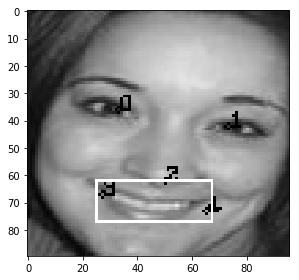

In [36]:
im_idx = 33
img = face_rec_data_pd.iloc[:,11:].iloc[im_idx].astype('uint8').values.reshape(HEIGHT, WIDTH)
img_lb = face_rec_data_pd.iloc[:,1:11].iloc[im_idx]
pts = get_inver_norm_pts(img_lb)
# for x, y in zip(pts[:,0], pts[:,1]):
img_cp = img.copy()
for i, pt in enumerate(pts):
    img_cp = cv.circle(img_cp, (pt[0], pt[1]), 1, (0,0,255), 1)
    cv.putText(img_cp, str(i), (pt[0], pt[1]), cv.FONT_HERSHEY_COMPLEX, 0.25, (0,255,0), 1)
    
fx, fy, fw, fh = get_mouth_box(pts)#find_face_param(pts)
cv.rectangle(img_cp, (fx, fy), (fx+fw, fy+fh), (255, 0, 0), 1)
    
imshow(img_cp)

## train model

In [7]:
WIDTH, HEIGHT = 96, 90

In [8]:
face_rec_data_pd = pd.read_csv('./data/face_5pt_img_data.zip')

In [9]:
face_data = face_rec_data_pd.iloc[:,11:].astype('uint8')
face_labels_pd = face_rec_data_pd.iloc[:,1:11]

In [10]:
face_data = face_data / 255

In [11]:
x = face_labels_pd.values[:,np.arange(0, 9, 2)] / WIDTH
y = face_labels_pd.values[:, np.arange(1, 11, 2)] / HEIGHT
labels = np.zeros(face_labels_pd.shape[0] * face_labels_pd.shape[1]).reshape(face_labels_pd.shape[0], face_labels_pd.shape[1])
labels[:,np.arange(0, 9, 2)] = x
labels[:, np.arange(1, 11, 2)] = y

In [12]:
face_data = face_data.values.reshape(-1, HEIGHT, WIDTH, 1)

In [13]:
random_seed = 5012
X_train, X_val, Y_train, Y_val = train_test_split(face_data, labels, test_size=0.3, random_state=random_seed)

In [18]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same',
                activation='relu', input_shape=(HEIGHT, WIDTH, 1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(2,2), padding='Same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(2,2), padding='Same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(units=10, activation='relu'))

In [19]:
# define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# compile the model
model.compile(optimizer=optimizer, loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 90, 96, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 48, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 24, 128)       32896     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 12, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16896)             0         
__________

In [20]:
# datagen = ImageDataGenerator(featurewise_center=False,
#                             samplewise_center=False,
#                             featurewise_std_normalization=False,
#                             samplewise_std_normalization=False,
#                             zca_whitening=False,
#                             rotation_range=10,
#                             zoom_range=0.2,
#                             width_shift_range=0.3,
#                             height_shift_range=0.3,
#                             horizontal_flip=False,
#                             vertical_flip=False)
# datagen.fit(X_train) #.reshape(-1, 2501, 8640, -1))

In [21]:
# set a early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)
# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.0001)
epochs = 10
batch_size = 80

In [65]:
# # without data augmentation
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, Y_val),
                    verbose=2,
                    callbacks=[learning_rate_reduction, early_stopping])
# with data augmentation
# history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), 
#                               epochs=epochs, 
#                               validation_data=(X_val, Y_val), 
#                               verbose=2, 
#                               steps_per_epoch=10, 
#                               callbacks=[learning_rate_reduction])

Train on 2266 samples, validate on 972 samples
Epoch 1/10
 - 25s - loss: 6.8728e-05 - val_loss: 2.6339e-05
Epoch 2/10
 - 28s - loss: 2.6345e-05 - val_loss: 2.6339e-05
Epoch 3/10
 - 29s - loss: 2.6345e-05 - val_loss: 2.6339e-05
Epoch 4/10
 - 24s - loss: 2.7110e-05 - val_loss: 2.6339e-05

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
 - 23s - loss: 2.6345e-05 - val_loss: 2.6339e-05
Epoch 6/10
 - 25s - loss: 2.6345e-05 - val_loss: 2.6339e-05
Epoch 7/10
 - 28s - loss: 2.6345e-05 - val_loss: 2.6339e-05

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 8/10
 - 26s - loss: 2.6345e-05 - val_loss: 2.6339e-05
Epoch 9/10
 - 26s - loss: 2.6345e-05 - val_loss: 2.6339e-05
Epoch 10/10
 - 33s - loss: 2.6345e-05 - val_loss: 2.6339e-05

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


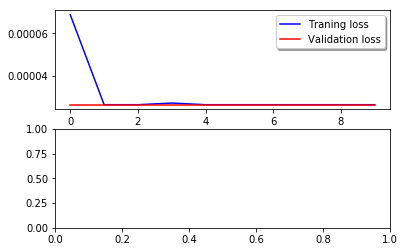

In [66]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Traning loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
# ax[1].plot(history.history['val_acc'], color='r', label='Validation accuracy')
# legend = ax[1].legend(loc='best', shadow=True)
fig.show()

In [67]:
model.save('./model/model_face_rec.h5')

## Check Performance

In [4]:
from keras.models import load_model

In [5]:
model = load_model('./model/model_face_rec.h5')
# model = load_model('./face_rec_with_label_norm.h5')

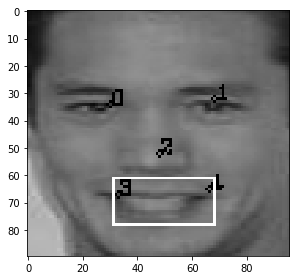

In [18]:
im_idx = 51
img = X_val[im_idx]
img_lb = model.predict((img).reshape(-1, HEIGHT, WIDTH, 1)).reshape(-1)
pts = get_inver_norm_pts(img_lb, is_unstd=True)

img_cp = img.copy().reshape(HEIGHT, WIDTH) * 255
img_cp = img_cp.astype('uint8')
for i, pt in enumerate(pts):
    img_cp = cv.circle(img_cp, (pt[0], pt[1]), 1, (0,0,255), 1)
    cv.putText(img_cp, str(i), (pt[0], pt[1]), cv.FONT_HERSHEY_COMPLEX, 0.25, (0,255,0), 1)
    
fx, fy, fw, fh = get_mouth_box(pts)
cv.rectangle(img_cp, (fx, fy), (fx+fw, fy+fh), (255, 0, 0), 1)
    
imshow(img_cp)

In [1]:
# img = normalize_img('/Users/Chen/Downloads/IMG_6957.JPG', 
#                     is_grey=True, 
#                     is_vectorize=False, 
#                     width=WIDTH, height=HEIGHT)#False)
# img = img / 255
# img_lb = model.predict((img).reshape(-1, HEIGHT, WIDTH, 1)).reshape(-1)
# pts = get_inver_norm_pts(img_lb, is_unstd=True)
# # for x, y in zip(pts[:,0], pts[:,1]):
# img_cp = img.copy().reshape(HEIGHT, WIDTH) * 255
# img_cp = img_cp.astype('uint8')
# for i, pt in enumerate(pts):
#     img_cp = cv.circle(img_cp, (pt[0], pt[1]), 1, (0,0,255), 1)
    
# fx, fy, fw, fh = find_face_param(pts)
# cv.rectangle(img_cp, (fx, fy), (fx+fw, fy+fh), (255, 0, 0), 1)
    
# imshow(img_cp)